# Base Result

In [ ]:
#Code used in Kaggle for testing

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
import lightgbm as lgbm
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split
import gc

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

// assign dtypes to minimize memory usage
dtypes = {
    'Id': 'object',
    'groupId': 'object',
    'matchId': 'object',
    'assists': 'uint8',
    'boosts': 'uint8',
    'damageDealt': 'float16',
    'DBNOs': 'uint8',
    'headshotKills': 'uint8',
    'heals': 'uint8',
    'killPlace': 'uint8',
    'killPoints': 'uint16',
    'kills': 'uint8',
    'killStreaks': 'uint8',
    'longestKill': 'float16',
    'maxPlace': 'uint8',
    'numGroups': 'uint8',
    'revives': 'uint8',
    'rideDistance': 'float16',
    'roadKills': 'uint8',
    'swimDistance': 'float16',
    'teamKills': 'uint8',
    'vehicleDestroys': 'uint8',
    'walkDistance': 'float16',
    'weaponsAcquired': 'uint8',
    'winPoints': 'uint8',
    'winPlacePerc': 'float16'
}

train_data = pd.read_csv("/kaggle/input/pubg-finish-placement-prediction/train_V2.csv", dtype=dtypes)
test_data = pd.read_csv("/kaggle/input/pubg-finish-placement-prediction/test_V2.csv", dtype=dtypes)

print(train_data.loc[:, train_data.isnull().any()].columns)
print(test_data.loc[:, test_data.isnull().any()].columns)

train_data[train_data['winPlacePerc'].isnull()]
train_data = train_data.dropna(subset=['winPlacePerc'])
train_data[train_data['winPlacePerc'].isnull()]

#split the data
data_train = train_data.copy()
data_test = test_data.copy()
data_train.drop(['Id','groupId','matchId', 'matchType'],axis=1,inplace=True)
data_test.drop(['Id','groupId','matchId', 'matchType'],axis=1,inplace=True)
X=data_train.drop(['winPlacePerc'],axis=1)
y=data_train['winPlacePerc']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,random_state=42)

# 1
regression = LinearRegression()
# 2
#regression = Lasso() 
# 3
#regression = Ridge()
# 4
# regression = RandomForestRegressor()
# 5
# regression = lightgbm.LGBMRegressor()

regression.fit(X_train, y_train)
predictions = regression.predict(data_test)
sub = pd.read_csv(r'/kaggle/input/pubg-finish-placement-prediction/sample_submission_V2.csv')
sub['winPlacePerc'] = predictions
sub.to_csv('submission.csv',index=False)

## Linear Regression

Linear Regression mse was 0.09171 on testset without any preprocessing and parameters tuning.

## Lasso

Lasso mse was 0.12045 on testset without any preprocessing and parameters tuning.

## Ridge

Ridge mse was 0.09171 on testset without any preprocessing and parameters tuning.Same as Linear regression.

## Random Forest Regressor

Random Forest Regressor mse was 0.06841 on testset without any preprocessing and parameters tuning.

## LightGBM

LightGBM mse was 0.05970 on testset without any preprocessing and parameters tuning.

In [2]:
base_results = [0.09171, 0.12045, 0.09171, 0.06841, 0.05970]
base_labels = ["Linear Regression", "Lasso", "Ridge", "Random Forest Regressor", "LightGBM"]

Text(0.5, 0, 'Model')

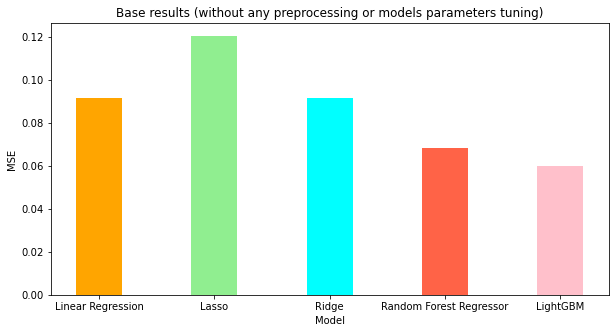

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize = (10, 5)) 
plt.bar(base_labels, base_results, width = 0.4, color = ["orange","lightgreen","cyan","tomato", "pink"])

plt.title("Base results (without any preprocessing or models parameters tuning)")
plt.ylabel('MSE')
plt.xlabel('Model')

# Models mse with preprocressing(matchType seperately) and parameters tuning

In [ ]:
#Code used in Kaggle for testing

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import precision_score
from sklearn.model_selection import train_test_split
import gc
import lightgbm as lgbm

def means_for_teams(data):
    g_data = data.groupby(['groupId']).mean()
    print(g_data.shape)

    for i, groupId in zip(data.index, data['groupId']):
        data.iloc[i][g_data.columns] = g_data.loc[groupId]
    return data

# features for duo or squad mode, these features are valued 0 in solo mode games
def drop_team_features(data):
    team_features = ['assists', 'DBNOs', 'revives', 'teamkills']
    return data.drop(team_features, axis=1)

def xy(data):
    X = data.drop('winPlacePerc', axis = 1).select_dtypes(['number'])
    y = data['winPlacePerc']
    return X, y

def fill_rankPoints(input_data, model = LinearRegression(), dropWinKillPoints=True):
    work_data = input_data.copy()
    work_data = pd.DataFrame(work_data.select_dtypes(['number']))

    #drop the other point features, since these will not be useful in predicting rankPoints
    work_data.drop(['winPoints', 'killPoints'], axis=1, inplace=True)

    #train the model with data where there are rankPoints
    train = pd.DataFrame(work_data.loc[data['rankPoints'] > 0, :])
    X_train = train.drop('rankPoints', axis=1)
    y_train = train['rankPoints']
    model.fit(X_train, y_train)

    #use model to predict missing rankPoints
    use = pd.DataFrame(work_data.loc[data['rankPoints'] <= 0, :])
    X_use = use.drop('rankPoints', axis=1)
    y_use = model.predict(X_use)

    #fill in the missing data
    work_data.loc[work_data['rankPoints'] <= 0, 'rankPoints'] = y_use

    return work_data


def print_top_feature_correlations_to_target_by_matchType(data, nrows):
    matchTypes = data['matchType'].value_counts().index.tolist()
    matchCounts = data['matchType'].value_counts().values.tolist()

    print("-----------------------------------------------------")
    print("Highest correlations to target feature BY matchType")
    print("Number of games:", nrows, "\n")
    for cnt, mt in zip(matchCounts, matchTypes):
        # for each matchtype
        # look at all the rows for that matchtype
        # and build a correlation matrix
        corr = data \
            .drop('winPlacePerc', axis=1) \
            .loc[data['matchType'] == mt] \
            .corrwith(data.loc[data['matchType'] == mt]['winPlacePerc'])
        corr = corr.sort_values(ascending=False)
        print("Type:", mt)
        print("Nr of games:", cnt)
        print(corr.head())
        print()


def scoreSets(dfs, random_state=1):
    for i, df in enumerate(dfs):
        lr = LinearRegression()
        x, y = xy(df)
        xtrain, xtest, ytrain, ytest = train_test_split(x, y, random_state=random_state)
        lr.fit(xtrain, ytrain)
        print("Score for set nr: ", i+1, lr.score(xtest, ytest))

def divide_by_matchType_and_aggregate_by_groupId(data):
    matchTypes = data['matchType'].value_counts().index.tolist()
    squadMatches = []
    duoMatches = []
    soloMatches = []
    otherMatches = []
    for match in matchTypes:
        if 'squad' in match or 'flare' in match:
            squadMatches.append(match)
        elif 'duo' in match or 'crash' in match:
            duoMatches.append(match)
        elif 'solo' in match:
            soloMatches.append(match)
        else:
            otherMatches.append(match)

    squadSet = pd.DataFrame(data.loc[data['matchType'].isin(squadMatches),:])
    duoSet = pd.DataFrame(data.loc[data['matchType'].isin(duoMatches),:])
    soloSet = pd.DataFrame(data.loc[data['matchType'].isin(soloMatches),:])

    squadMeanSet = pd.DataFrame(squadSet.groupby('groupId').mean(), dtype='float16')
    duoMeanSet = pd.DataFrame(duoSet.groupby('groupId').mean(), dtype='float16')

    squadSets = [squadSet, squadMeanSet]
    duoSets = [duoSet, duoMeanSet]

    #print("Returning [[squadSet, squadMeanSet], [duoSet, duoMeanSet], soloSet]")
    return [squadSets, duoSets, soloSet]


# assign dtypes to minimize memory usage
dtypes = {
    'Id': 'object',
    'groupId': 'object',
    'matchId': 'object',
    'assists': 'uint8',
    'boosts': 'uint8',
    'damageDealt': 'float16',
    'DBNOs': 'uint8',
    'headshotKills': 'uint8',
    'heals': 'uint8',
    'killPlace': 'uint8',
    'killPoints': 'uint16',
    'kills': 'uint8',
    'killStreaks': 'uint8',
    'longestKill': 'float16',
    'maxPlace': 'uint8',
    'numGroups': 'uint8',
    'revives': 'uint8',
    'rideDistance': 'float16',
    'roadKills': 'uint8',
    'swimDistance': 'float16',
    'teamKills': 'uint8',
    'vehicleDestroys': 'uint8',
    'walkDistance': 'float16',
    'weaponsAcquired': 'uint8',
    'winPoints': 'uint8',
    'winPlacePerc': 'float16'
}

train_data = pd.read_csv("/kaggle/input/pubg-finish-placement-prediction/train_V2.csv", dtype=dtypes)
test_data = pd.read_csv("/kaggle/input/pubg-finish-placement-prediction/test_V2.csv", dtype=dtypes)

#print(train_data.loc[:, train_data.isnull().any()].columns)
#print(test_data.loc[:, test_data.isnull().any()].columns)

train_data[train_data['winPlacePerc'].isnull()]

train_data = train_data.dropna(subset=['winPlacePerc'])

#train_data[train_data['winPlacePerc'].isnull()]

# train_data - Training data with feature "winPlacePerc"
# test_data - Testing data without feature "winPlacePerc"
# models - models for solo, dua and squad prediction as list [model for solo, model for duo, model for squad]

def testPredictions(train_data, test_data, models):

    train = train_data
    test = test_data
   
    trainSets = divide_by_matchType_and_aggregate_by_groupId(train)
    testSets = divide_by_matchType_and_aggregate_by_groupId(test)
    
    all_predictions = pd.DataFrame()
    for train, test, model in zip(trainSets, testSets, models):
        if len(train) == 2:
            trainset = train[0]
            meanTrainSet = train[1] #only numeric values, the index is 'groupId'
            testset = test[0]
            X_test = test[1]

            X_train = meanTrainSet.drop('winPlacePerc', axis=1)
            y_train = meanTrainSet.winPlacePerc

            model.fit(X_train, y_train)

            yhat = model.predict(X_test)

            #now I will rejoin the prediction with the original row index
            yhat = pd.DataFrame(yhat, index=X_test.index,columns=['prediction'])
            testset = testset.join(yhat, on='groupId')
            yhat = testset.drop(testset.columns.difference(['prediction']), axis=1)

        else:
            X_train = train.select_dtypes(['number']).drop('winPlacePerc', axis=1)
            y_train = train.winPlacePerc
            X_test = pd.DataFrame(test.select_dtypes(['number']))

            model.fit(X_train, y_train)
            yhat = model.predict(X_test)

            X_test['prediction'] = yhat
            yhat = pd.DataFrame(X_test['prediction'], index=X_test.index, dtype='float32')

        all_predictions = all_predictions.append(yhat)

    all_predictions.sort_index(inplace=True)

    return all_predictions


# 1
solo_mod = LinearRegression(fit_intercept = True, normalize = False, n_jobs = -1)
duo_mod = LinearRegression(fit_intercept = True, normalize = False, n_jobs = -1)
squad_mod = LinearRegression(fit_intercept = True, normalize = False, n_jobs = -1)

# 2
#solo_mod = Lasso(fit_intercept = True, normalize = False, alpha = 0.0001, max_iter = 2500)
#duo_mod = Lasso(fit_intercept = True, normalize = False, alpha = 0.0001, max_iter = 2500)
#squad_mod = Lasso(fit_intercept = True, normalize = False, alpha = 0.0001, max_iter = 2500)

# 3
#solo_mod = Ridge(fit_intercept = True, normalize = False, alpha = 1, tol =  0.001, solver = 'auto')
#duo_mod = Ridge(fit_intercept = True, normalize = False, alpha = 1, tol =  0.001, solver = 'auto')
#squad_mod = Ridge(fit_intercept = True, normalize = False, alpha = 1, tol =  0.001, solver = 'auto')

# 4
#solo_mod = RandomForestRegressor(n_estimators=150, max_features=0.5,min_samples_split = 2, min_samples_leaf=3, n_jobs=-1,verbose=2)
#duo_mod = RandomForestRegressor(n_estimators=150, max_features=0.5,min_samples_split = 2, min_samples_leaf=3, n_jobs=-1, verbose=2)
#squad_mod = RandomForestRegressor(n_estimators=150, max_features=0.5,min_samples_split = 2, min_samples_leaf=3, n_jobs=-1, verbose=2)

# 5
#solo_mod = lightgbm.LGBMRegressor(objective = "regression",metric = "mae",num_leaves =  128,verbose =  1, n_estimators=150)
#duo_mod = lightgbm.LGBMRegressor(objective = "regression",metric = "mae",num_leaves =  128,verbose =  1, n_estimators=150)
#squad_mod = lightgbm.LGBMRegressor(objective = "regression",metric = "mae",num_leaves =  128,verbose =  1, n_estimators=150)

models = [solo_mod, duo_mod, squad_mod]

train_d = train_data
test_d = test_data

all_predictions = testPredictions(train_d, test_d, models)
sub = pd.read_csv(r'/kaggle/input/pubg-finish-placement-prediction/sample_submission_V2.csv')
sub['winPlacePerc'] = all_predictions['prediction']
sub['winPlacePerc'] = predictions
sub.to_csv('submission.csv',index=False)

## Linear Regression with preprocressing(matchType seperately) and parameters tuning

Linear Regression mse was 0.07170 on testset with preprocressing(matchType seperately) and parameters tuning.

## Lasso with preprocressing(matchType seperately) and parameters tuning

Lasso mse was 0.07473 on testset with preprocressing(matchType seperately) and parameters tuning.

## Ridge with preprocressing(matchType seperately) and parameters tuning

Ridge mse was 0.0695 on testset with preprocressing(matchType seperately) and parameters tuning.

## Random Forest Regressor with preprocressing(matchType seperately) and parameters tuning

Random Forest Regressor mse was 0.05202 on testset with preprocressing(matchType seperately) and parameters tuning.

## LightGBM with preprocressing(matchType seperately) and parameters tuning


Random Forest Regressor mse was 0.05034 on testset with preprocressing(matchType seperately) and parameters tuning.

In [33]:
results = [0.07170, 0.07473, 0.0695, 0.05202, 0.05034]
labels = ["Linear Regression", "Lasso", "Ridge", "Random Forest Regressor", "LightGBM"]

Text(0.5, 0, 'Model')

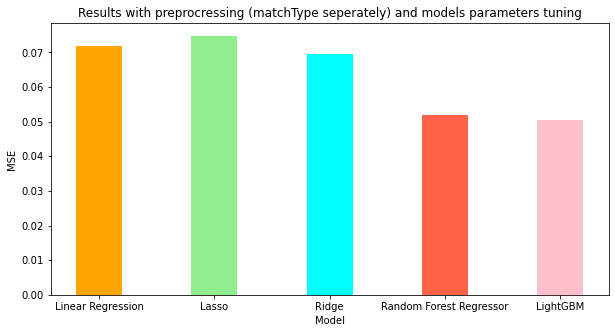

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize = (10, 5)) 
plt.bar(labels, results, width = 0.4, color = ["orange","lightgreen","cyan","tomato", "pink"])

plt.title("Results with preprocressing (matchType seperately) and models parameters tuning")
plt.ylabel('MSE')
plt.xlabel('Model')

In [ ]:
0.06841